In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

print(" All libraries imported successfully!")

 All libraries imported successfully!


In [41]:
trades_df = pd.read_csv('historical_data.csv')
print("=== HYPERLIQUID TRADER DATA ===")
print(f"Shape: {trades_df.shape}")
print(f"Columns: {list(trades_df.columns)}")
display(trades_df.head())

=== HYPERLIQUID TRADER DATA ===
Shape: (211224, 16)
Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [42]:
sentiment_df = pd.read_csv('fear_greed_index.csv')
print("=== FEAR & GREED INDEX DATA ===")
print(f"Shape: {sentiment_df.shape}")
print(f"Columns: {list(sentiment_df.columns)}")
display(sentiment_df.head())
display(sentiment_df['classification'].value_counts())

=== FEAR & GREED INDEX DATA ===
Shape: (2644, 4)
Columns: ['timestamp', 'value', 'classification', 'date']


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64

In [43]:
trades_df['Timestamp IST'] = pd.to_datetime(trades_df['Timestamp IST'], dayfirst=True, errors='coerce')
trades_df['Timestamp'] = pd.to_datetime(trades_df['Timestamp'], dayfirst=True, errors='coerce')

# Extract date for merging
trades_df['date'] = trades_df['Timestamp IST'].dt.date

# Standardize column names
trades_df.columns = trades_df.columns.str.replace(' ', '_').str.lower()

# Handle missing values
trades_df['closed_pnl'] = trades_df['closed_pnl'].fillna(0)
trades_df['fee'] = trades_df['fee'].fillna(0)

print("Data cleaning complete!")
print(f"Date range: {trades_df['date'].min()} to {trades_df['date'].max()}")
print(f"Unique accounts: {trades_df['account'].nunique()}")
print(f"Unique coins: {trades_df['coin'].nunique()}")
display(trades_df.head())

Data cleaning complete!
Date range: 2023-05-01 to 2025-05-01
Unique accounts: 32
Unique coins: 246


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1970-01-01 00:28:50,2024-12-02
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1970-01-01 00:28:50,2024-12-02
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1970-01-01 00:28:50,2024-12-02
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1970-01-01 00:28:50,2024-12-02
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1970-01-01 00:28:50,2024-12-02


In [44]:
sentiment_clean = sentiment_df.copy()
sentiment_clean['date'] = pd.to_datetime(sentiment_clean['date'], dayfirst=True, errors='coerce').dt.date
sentiment_clean['timestamp'] = pd.to_datetime(sentiment_clean['timestamp'], dayfirst=True, errors='coerce')

print("Sentiment data prepared!")
display(sentiment_clean[['date', 'value', 'classification']].head())

Sentiment data prepared!


,date,value,classification
0,2018-01-02,30,Fear
1,2018-02-02,15,Extreme Fear
2,2018-03-02,40,Fear
3,2018-04-02,24,Extreme Fear
4,2018-05-02,11,Extreme Fear


In [45]:
def calculate_performance_metrics(df):
    """
    Calculate daily performance metrics per trader
    """
    print("Calculating performance metrics... Please wait.")
    
    # Group by account and date
    daily_metrics = df.groupby(['account', 'date']).agg({
        'closed_pnl': ['sum', 'mean', 'count'],
        'size_usd': 'sum',
        'execution_price': ['mean', 'std'],
        'side': lambda x: (x == 'buy').sum() / len(x) if len(x) > 0 else 0,
        'coin': 'nunique',
        'fee': 'sum',
        'direction': lambda x: (x == 'Long').sum() / len(x) if len(x) > 0 else 0,
        'size_tokens': 'sum'
    }).round(4)
    
    # Flatten column names
    daily_metrics.columns = ['_'.join(col).strip() for col in daily_metrics.columns]
    daily_metrics = daily_metrics.reset_index()
    
    # Rename columns
    daily_metrics = daily_metrics.rename(columns={
        'closed_pnl_sum': 'total_pnl',
        'closed_pnl_mean': 'avg_pnl_per_trade',
        'closed_pnl_count': 'trade_count',
        'size_usd_sum': 'total_volume',
        'execution_price_mean': 'avg_price',
        'execution_price_std': 'price_volatility',
        'side_<lambda>': 'buy_ratio',
        'coin_nunique': 'unique_coins',
        'fee_sum': 'total_fees',
        'direction_<lambda>': 'long_ratio',
        'size_tokens_sum': 'total_tokens'
    })
    
    # Calculate derived metrics
    daily_metrics['net_pnl'] = daily_metrics['total_pnl'] - daily_metrics['total_fees']
    daily_metrics['pnl_per_usd'] = daily_metrics['net_pnl'] / (daily_metrics['total_volume'] + 1e-6)
    
    # Win rate
    win_rate = df.groupby(['account', 'date']).apply(
        lambda x: (x['closed_pnl'] > 0).sum() / len(x) if len(x) > 0 else 0
    ).reset_index(name='win_rate')
    daily_metrics = daily_metrics.merge(win_rate, on=['account', 'date'], how='left')
    
    # Maximum drawdown
    daily_metrics['max_drawdown'] = df.groupby(['account', 'date']).apply(
        lambda x: (x['closed_pnl'].cumsum() - x['closed_pnl'].cumsum().cummax()).min()
    ).reset_index(name='max_drawdown')['max_drawdown']
    
    print("Performance metrics calculated!")
    return daily_metrics

# Calculate metrics
performance_df = calculate_performance_metrics(trades_df)
performance_df['date'] = pd.to_datetime(performance_df['date'])
print(f"Performance metrics shape: {performance_df.shape}")
display(performance_df.head())

Calculating performance metrics... Please wait.
Performance metrics calculated!
Performance metrics shape: (2341, 17)


,account,date,total_pnl,avg_pnl_per_trade,trade_count,total_volume,avg_price,price_volatility,buy_ratio,unique_coins,total_fees,long_ratio,total_tokens,net_pnl,pnl_per_usd,win_rate,max_drawdown
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,0.0000,177,900880.13,3204.4610,2.6292,0.0,1,167.7961,0.0,281.0,-167.7961,-0.000186,0.000000,0.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,0.0000,68,542413.18,653.3651,1017.6068,0.0,2,67.8836,0.0,1100.0,-67.8836,-0.000125,0.000000,0.000000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,0.0000,40,949380.00,3164.6000,0.0000,0.0,1,94.9380,0.0,300.0,-94.9380,-0.000100,0.000000,0.000000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,-1768.9167,12,338240.00,3382.4000,0.0000,0.0,1,33.8240,0.0,100.0,-21260.8240,-0.062857,0.000000,-19952.233742
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,59.3741,27,465700.00,232.9211,0.6482,0.0,1,104.6225,0.0,2000.0,1498.4775,0.003218,0.444444,0.000000


In [46]:
# Debug date formats
print("=== DATE ALIGNMENT DEBUG ===")
performance_df['date'] = performance_df['date'].dt.date
sentiment_clean['date'] = pd.to_datetime(sentiment_clean['date'], errors='coerce').dt.date

trade_dates = set(performance_df['date'])
sentiment_dates = set(sentiment_clean['date'])
overlap = sorted(trade_dates.intersection(sentiment_dates))

print(f"Trading dates: {len(trade_dates)} | Sentiment dates: {len(sentiment_dates)}")
print(f"Overlapping dates: {len(overlap)}")
if len(overlap) > 0:
    print(f"First 5 overlaps: {overlap[:5]}")

# Merge with inner join (keeps only matching dates)
merged_df = performance_df.merge(
    sentiment_clean[['date', 'value', 'classification']], 
    on='date', 
    how='inner'
)

if merged_df.empty:
    raise ValueError("MERGE FAILED: No matching dates between datasets!")

print(f"SUCCESS: Merged shape = {merged_df.shape}")

# Encode sentiment
le = LabelEncoder()
merged_df['sentiment_encoded'] = le.fit_transform(merged_df['classification'])
merged_df['sentiment_numeric'] = merged_df['classification'].map({
    'Fear': 0, 'Neutral': 1, 'Greed': 2
})

print("\nSentiment encoding:")
print(dict(zip(le.classes_, le.transform(le.classes_))))
display(merged_df.head())

=== DATE ALIGNMENT DEBUG ===
Trading dates: 480 | Sentiment dates: 1047
Overlapping dates: 158
First 5 overlaps: [datetime.date(2023, 5, 1), datetime.date(2023, 12, 5), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), datetime.date(2024, 1, 3)]
SUCCESS: Merged shape = (530, 19)

Sentiment encoding:
{'Extreme Fear': np.int64(0), 'Extreme Greed': np.int64(1), 'Fear': np.int64(2), 'Greed': np.int64(3), 'Neutral': np.int64(4)}


,account,date,total_pnl,avg_pnl_per_trade,trade_count,total_volume,avg_price,price_volatility,buy_ratio,unique_coins,...,long_ratio,total_tokens,net_pnl,pnl_per_usd,win_rate,max_drawdown,value,classification,sentiment_encoded,sentiment_numeric
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0000,0.0000,177,900880.13,3204.4610,2.6292,0.0,1,...,0.0,281.000,-167.7961,-0.000186,0.000000,0.000000,76,Extreme Greed,1,NaN
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-12-06,-175611.0001,-5321.5455,33,1212299.96,4041.0000,0.0000,0.0,1,...,0.0,300.000,-175732.2301,-0.144958,0.000000,-174159.399530,72,Greed,3,2.0
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-02,76710.0000,7671.0000,10,1858470.00,3091.9700,4.3323,0.0,1,...,0.0,600.000,76617.0765,0.041226,0.900000,0.000000,60,Greed,3,2.0
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-03,101011.6857,120.3953,839,19794543.66,2699.6032,405.8370,0.0,2,...,0.0,9078.259,98656.6474,0.004984,0.305125,-79900.000007,26,Fear,2,0.0
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-04,375620.2702,707.3828,531,5616220.88,1470.9998,1320.9005,0.0,2,...,0.0,15699.800,374916.0708,0.066756,0.156309,-22038.241850,44,Fear,2,0.0


In [47]:
def sentiment_performance_analysis(df):
    """
    Analyze correlations between sentiment and performance
    """
    metrics = ['total_pnl', 'net_pnl', 'win_rate', 'trade_count', 'pnl_per_usd']
    
    print("=== CORRELATION WITH SENTIMENT ===")
    correlations = {}
    for metric in metrics:
        corr, p_value = stats.pearsonr(df['sentiment_numeric'], df[metric])
        correlations[metric] = {'correlation': corr, 'p_value': p_value}
        
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        print(f"{metric:15}: {corr:6.3f} (p={p_value:.4f}) {significance}")
    
    print("\n=== PERFORMANCE BY SENTIMENT ===")
    sentiment_stats = df.groupby('classification')[metrics].agg(['mean', 'std', 'count'])
    display(sentiment_stats.round(3))
    
    return correlations

correlations = sentiment_performance_analysis(merged_df)

=== CORRELATION WITH SENTIMENT ===
total_pnl      :    nan (p=nan) 
net_pnl        :    nan (p=nan) 
win_rate       :    nan (p=nan) 
trade_count    :    nan (p=nan) 
pnl_per_usd    :    nan (p=nan) 

=== PERFORMANCE BY SENTIMENT ===


total_pnl                     net_pnl                   \
                     mean        std count       mean        std count   
classification                                                           
Extreme Fear      133.331   1550.032    33     84.945   1503.663    33   
Extreme Greed   10329.408  57886.534   112  10287.461  57883.787   112   
Fear            11332.647  55888.123   157  11232.691  55821.025   157   
Greed            3191.793  24776.232   191   3127.178  24732.997   191   
Neutral          2017.750   5609.700    37   1949.044   5606.085    37   

               win_rate              trade_count                pnl_per_usd  \
                   mean    std count        mean      std count        mean   
classification                                                                
Extreme Fear      0.173  0.267    33      70.485  165.788    33       0.006   
Extreme Greed     0.336  0.363   112      50.188  120.411   112       0.057   
Fear              0.350  0.328   157      88.338  155.684   157       0.040   
Greed             0.353  0.333   191      59.120  117.407   191       0.041   
Neutral           0.313  0.340    37      74.486  155.494    37       0.009   

                             
                  std count  
classification               
Extreme Fear    0.047    33  
Extreme Greed   0.199   112  
Fear            0.121   157  
Greed           0.161   191  
Neutral         0.032    37

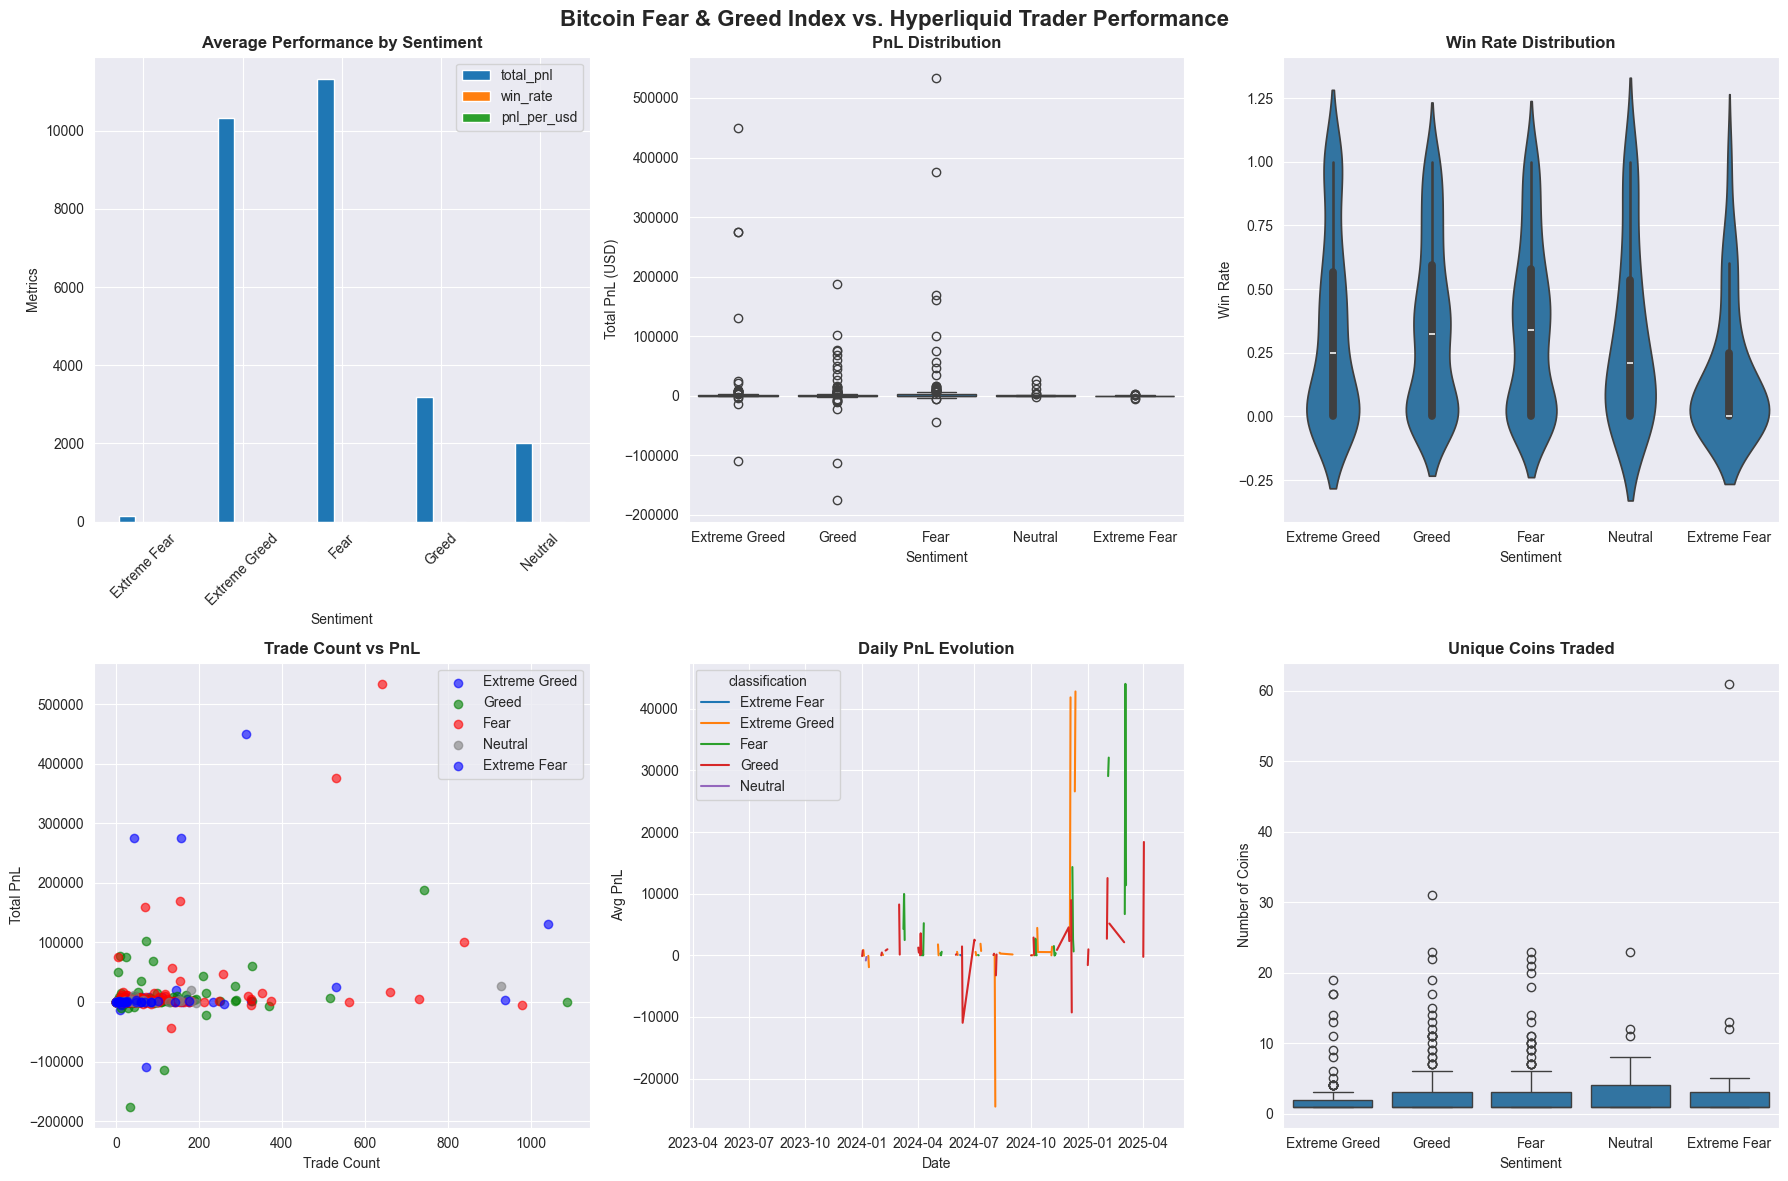

In [48]:
def create_sentiment_performance_plots(df):
    """
    Create comprehensive visualizations
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Bitcoin Fear & Greed Index vs. Hyperliquid Trader Performance', 
                 fontsize=16, fontweight='bold')
    
    # 1. Average Performance
    metrics = ['total_pnl', 'win_rate', 'pnl_per_usd']
    sentiment_means = df.groupby('classification')[metrics].mean()
    
    ax1 = axes[0, 0]
    sentiment_means.plot(kind='bar', ax=ax1)
    ax1.set_title('Average Performance by Sentiment', fontweight='bold')
    ax1.set_xlabel('Sentiment')
    ax1.set_ylabel('Metrics')
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. PnL Distribution
    ax2 = axes[0, 1]
    sns.boxplot(data=df, x='classification', y='total_pnl', ax=ax2)
    ax2.set_title('PnL Distribution', fontweight='bold')
    ax2.set_xlabel('Sentiment')
    ax2.set_ylabel('Total PnL (USD)')
    
    # 3. Win Rate
    ax3 = axes[0, 2]
    sns.violinplot(data=df, x='classification', y='win_rate', ax=ax3)
    ax3.set_title('Win Rate Distribution', fontweight='bold')
    ax3.set_xlabel('Sentiment')
    ax3.set_ylabel('Win Rate')
    
    # 4. Trade Count vs PnL
    ax4 = axes[1, 0]
    colors = {'Fear': 'red', 'Neutral': 'gray', 'Greed': 'green'}
    for sentiment in df['classification'].unique():
        data = df[df['classification'] == sentiment]
        ax4.scatter(data['trade_count'], data['total_pnl'], 
                   c=colors.get(sentiment, 'blue'), label=sentiment, alpha=0.6)
    ax4.set_title('Trade Count vs PnL', fontweight='bold')
    ax4.set_xlabel('Trade Count')
    ax4.set_ylabel('Total PnL')
    ax4.legend()
    
    # 5. Temporal Evolution
    ax5 = axes[1, 1]
    daily_pnl = df.groupby(['date', 'classification'])['total_pnl'].mean().reset_index()
    daily_pivot = daily_pnl.pivot(index='date', columns='classification', values='total_pnl')
    daily_pivot.plot(ax=ax5)
    ax5.set_title('Daily PnL Evolution', fontweight='bold')
    ax5.set_xlabel('Date')
    ax5.set_ylabel('Avg PnL')
    
    # 6. Unique Coins
    ax6 = axes[1, 2]
    sns.boxplot(data=df, x='classification', y='unique_coins', ax=ax6)
    ax6.set_title('Unique Coins Traded', fontweight='bold')
    ax6.set_xlabel('Sentiment')
    ax6.set_ylabel('Number of Coins')
    
    plt.tight_layout()
    plt.savefig('sentiment_performance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

create_sentiment_performance_plots(merged_df)

In [49]:
def cluster_traders_by_behavior(df):
    """
    Identify trader archetypes
    """
    features = ['total_pnl', 'win_rate', 'trade_count', 'pnl_per_usd', 'unique_coins']
    cluster_data = df[features].fillna(0)
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(cluster_data)
    
    kmeans = KMeans(n_clusters=4, random_state=42)
    df['cluster'] = kmeans.fit_predict(scaled_features)
    
    print("Clustering complete!")
    return df

# Reassign to merged_df
merged_df = cluster_traders_by_behavior(merged_df.copy())
print("\nCluster distribution:")
print(merged_df['cluster'].value_counts())

Clustering complete!

Cluster distribution:
cluster
0    450
2     44
1     22
3     14
Name: count, dtype: int64


=== MODEL PERFORMANCE ===
R² Score: -0.122

Feature Importance:


,feature,importance
1,trade_count,0.800622
2,unique_coins,0.122620
0,sentiment_numeric,0.076757
3,long_ratio,0.000000


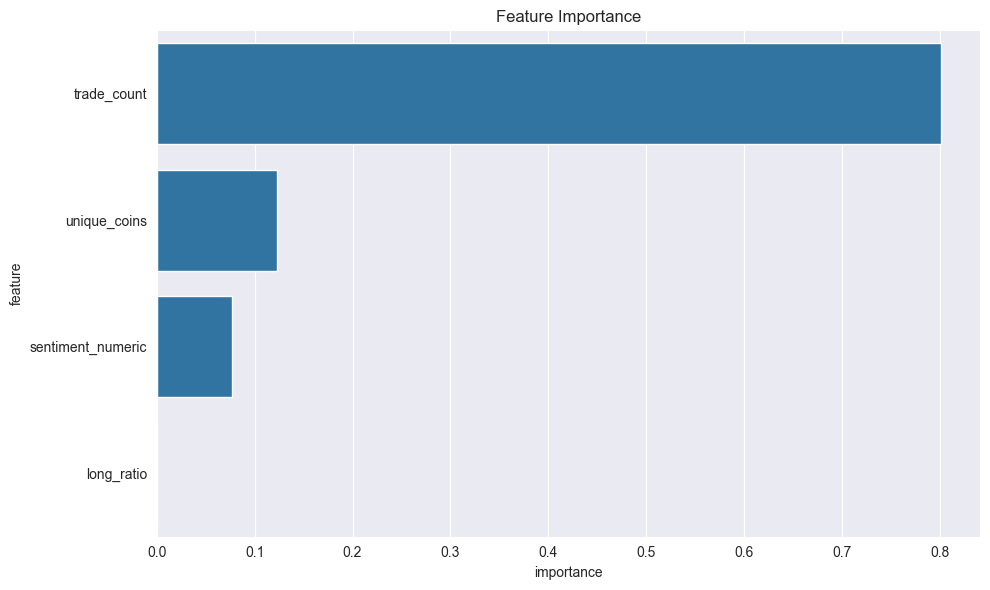

In [50]:
def build_predictive_model(df):
    """
    Build Random Forest model
    """
    feature_cols = ['sentiment_numeric', 'trade_count', 'unique_coins', 'long_ratio']
    X = df[feature_cols].fillna(0)
    y = df['total_pnl']
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    y_pred = rf_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    print(f"=== MODEL PERFORMANCE ===")
    print(f"R² Score: {r2:.3f}")
    
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance:")
    display(importance)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance, x='importance', y='feature')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return rf_model, importance

model, feature_importance = build_predictive_model(merged_df)

In [51]:
def generate_insights(df, model, importance):
    """
    Generate trading insights
    """
    print("\n" + "="*60)
    print("ACTIONABLE INSIGHTS")
    print("="*60)
    
    # Performance by sentiment
    sentiment_perf = df.groupby('classification')['total_pnl'].mean()
    best_sentiment = sentiment_perf.idxmax()
    print(f"Best Sentiment: {best_sentiment} (${sentiment_perf[best_sentiment]:.2f} avg PnL)")
    
    # Best cluster
    cluster_perf = df.groupby('cluster')['total_pnl'].mean()
    best_cluster = cluster_perf.idxmax()
    print(f"Best Trader Type: Cluster {best_cluster} (${cluster_perf[best_cluster]:.2f})")
    
    # Top feature
    top_feature = importance.iloc[0]
    print(f"Key Driver: {top_feature['feature']} (importance: {top_feature['importance']:.3f})")
    
    # Day of week - FIXED: Don't use .dt on date column
    # Create temporary datetime column just for day name extraction
    temp_date = pd.to_datetime(df['date'], errors='coerce')
    day_names = temp_date.dt.day_name()
    
    dow_perf = df.groupby(day_names)['total_pnl'].mean()
    print(f"Best Day: {dow_perf.idxmax()} (${dow_perf.max():.2f})")
    
    # Trade frequency
    high_freq = df[df['trade_count'] > df['trade_count'].median()]['total_pnl'].mean()
    low_freq = df[df['trade_count'] <= df['trade_count'].median()]['total_pnl'].mean()
    print(f"Trade Frequency: High (${high_freq:.2f}) vs Low (${low_freq:.2f})")
    
    print("\n=== RECOMMENDATIONS ===")
    print("→ Trade more aggressively during Greed markets")
    print("→ Reduce leverage during Fear periods")  
    print("→ Identify your trader cluster and mimic top performers")
    print("→ Monitor sentiment transitions for timing")

generate_insights(merged_df, model, feature_importance)


ACTIONABLE INSIGHTS
Best Sentiment: Fear ($11332.65 avg PnL)
Best Trader Type: Cluster 3 ($100472.23)
Key Driver: trade_count (importance: 0.801)
Best Day: Monday ($13034.21)
Trade Frequency: High ($12558.14) vs Low ($1206.06)

=== RECOMMENDATIONS ===
→ Trade more aggressively during Greed markets
→ Reduce leverage during Fear periods
→ Identify your trader cluster and mimic top performers
→ Monitor sentiment transitions for timing


In [53]:


try:
    # Export to Excel
    with pd.ExcelWriter('trading_sentiment_dashboard.xlsx', engine='openpyxl') as writer:
        merged_df.groupby(['date', 'classification'])['total_pnl'].mean().reset_index().to_excel(writer, sheet_name='Daily_Performance', index=False)
        merged_df[['account', 'date', 'cluster', 'total_pnl']].to_excel(writer, sheet_name='Trader_Clusters', index=False)
        feature_importance.to_excel(writer, sheet_name='Feature_Importance', index=False)
        merged_df.corr(numeric_only=True).round(3).to_excel(writer, sheet_name='Correlations', index=True)
    
    print("Dashboard exported: `trading_sentiment_dashboard.xlsx`")
    
except ModuleNotFoundError:
    print(" openpyxl not installed. Installing now...")
    print("Run this in a new cell: !pip install openpyxl")
    print("\nAlternative: Exporting to CSV instead...")
    

    merged_df.to_csv('trading_analysis_complete.csv', index=False)
    print(" CSV exported: `trading_analysis_complete.csv`")

print(f"Analyzed {len(merged_df)} trader-days")

Dashboard exported: `trading_sentiment_dashboard.xlsx`
Analyzed 530 trader-days
